In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from implementations import *
from helpers import *

### Load data

In [2]:
DATA_FOLDER = 'data/'

In [3]:
try:
    with open(DATA_FOLDER + 'x_train.pickle', 'rb') as f:
        x_train = pickle.load(f)
    with open(DATA_FOLDER + 'x_test.pickle', 'rb') as f:
        x_test = pickle.load(f)
    with open(DATA_FOLDER + 'y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
    with open(DATA_FOLDER + 'test_ids.pickle', 'rb') as f:
        test_ids = pickle.load(f)
except:
    x_train, x_test, y_train, train_ids, test_ids = load_csv_data(DATA_FOLDER, sub_sample=False)

    names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
    names = np.delete(names, 0)
    names_map = {}
    for i in range(len(names)):
        names_map[names[i]] = i

    x_train[np.isnan(x_train)] = 0
    x_test[np.isnan(x_test)] = 0

    with open(DATA_FOLDER + 'x_train.pickle', 'wb') as f:
        pickle.dump(x_train, f)

    with open(DATA_FOLDER + 'x_test.pickle', 'wb') as f:
        pickle.dump(x_test, f)

    with open(DATA_FOLDER + 'y_train.pickle', 'wb') as f:
        pickle.dump(y_train, f)

    with open(DATA_FOLDER + 'test_ids.pickle', 'wb') as f:
        pickle.dump(test_ids, f)

In [4]:
# y_train = np.where(y_train == -1, 0, y_train)

### Sort of Cross-Validation on lambda and gamma

In [5]:
def build_k_indices(y, k_fold, seed):
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [6]:
def cross_validation(y, x, k_indices, k, lambda_, gamma, max_iters, initial_w):
    # ***************************************************
    val_indices = k_indices[k]
    tr_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].flatten()
    
    y_val = y[val_indices]
    y_tr = y[tr_indices]
    x_val_cv = x[val_indices]
    x_tr_cv = x[tr_indices]

    w, losses, gen_losses = my_reg_logistic_regression(y_tr, x_tr_cv, y_val, x_val_cv, lambda_, initial_w, max_iters,
                                                       gamma)
    loss_tr = np.min(losses)
    loss_val = np.min(gen_losses)
    # ***************************************************
    return loss_tr, loss_val

In [7]:
def preprocess_data(x):
    # Prepare data for cross-validation
    x_tr_cv = x.copy()
    # x_tr_cv = x_tr.copy()
    # x_val_cv = x_val.copy()
    
    # Scaling each column
    for i in range(x_tr_cv.shape[1]):
        x_tr_cv[:, i] = (x_tr_cv[:, i] - np.mean(x_tr_cv[:, i])) / np.std(x_tr_cv[:, i])
        # x_val_cv[:, i] = (x_val_cv[:, i] - np.mean(x_val_cv[:, i])) / np.std(x_val_cv[:, i])
    
    # Adding an intercept   
    x_tr_cv = np.c_[np.ones((x_tr_cv.shape[0], 1)), x_tr_cv]
    # x_val_cv = np.c_[np.ones((x_val_cv.shape[0], 1)), x_val_cv]
    
    return x_tr_cv

In [8]:
max_iters = 5

k_fold = 5

losses_list = []
gen_losses_list = []

# split data in k fold
k_indices = build_k_indices(y_train, k_fold, 42)

### Polynomial expansion

In [8]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    feature_matrix = np.zeros((x.shape[0], degree * x.shape[1]))
    
    for i in range(1, degree + 1):
        feature_matrix[:, (i - 1) * x.shape[1]:i * x.shape[1]] = x ** i
        
    return feature_matrix

### CV on everything

In [14]:
%%time

best_lambda_gammas = []
best_losses = []

lambdas = [.005, .01, .05]
gammas = [.01, .05, .1, .2]
lambda_gammas = [(lambdas[i], gammas[j]) for j in range(len(gammas)) for i in range(len(lambdas))]
degrees = [3, 4]
max_iters = 10

for degree in degrees:
    x_tr_exp = build_poly(x_train, degree)   
    x_tr_cv = preprocess_data(x_tr_exp)
    
    loss_degree = []
    for lambda_, gamma in lambda_gammas:
        loss_l_g = []
        
        for k in range(k_fold):
            _, loss_validation = cross_validation(y_train, x_tr_cv, k_indices, k, lambda_, gamma, max_iters, np.zeros(x_tr_cv.shape[1]))
            loss_l_g.append(loss_validation)
        loss_degree.append(np.mean(loss_l_g))

    ind_lambda_gamma_opt = np.argmin(loss_degree)
    best_lambda_gammas.append(lambda_gammas[ind_lambda_gamma_opt])
    best_losses.append(loss_degree[ind_lambda_gamma_opt])

ind_best_degree = np.argmin(best_losses)
best_degree = degrees[ind_best_degree]
best_lambda, best_gamma = best_lambda_gammas[ind_best_degree]
best_loss = best_losses[ind_best_degree]

print(f"Best degree: {best_degree}, best lambda: {best_lambda}, best gamma: {best_gamma}, best loss: {best_loss}")

Best degree: 3, best lambda: 0.005, best gamma: 0.2, best loss: 0.4912204205687969
CPU times: total: 44min 29s
Wall time: 1h 21min 40s


### Training

In [10]:
best_lambda = .005
best_gamma = 0.2
best_degree = 3

In [11]:
# separate training and validation dataset
ratio = 0.8
np.seed = 42
n = x_train.shape[0]
train_indices = np.random.choice(n, int(ratio * n), replace=False)

x_tr, y_tr, x_val, y_val = x_train[train_indices, :], y_train[train_indices], np.delete(x_train, train_indices,
                                                                                        axis=0), np.delete(y_train,
                                                                                                           train_indices,
                                                                                                           axis=0)

In [12]:
degree = best_degree

x_tr_exp = build_poly(x_tr, degree)
x_val_exp = build_poly(x_val, degree)

# Scaling each column
for i in range(x_tr_exp.shape[1]):
    x_tr_exp[:, i] = (x_tr_exp[:, i] - np.mean(x_tr_exp[:, i])) / np.std(x_tr_exp[:, i])
    x_val_exp[:, i] = (x_val_exp[:, i] - np.mean(x_val_exp[:, i])) / np.std(x_val_exp[:, i])

# Adding an intercept
x_tr_exp = np.c_[np.ones((x_tr_exp.shape[0], 1)), x_tr_exp]
x_val_exp = np.c_[np.ones((x_val_exp.shape[0], 1)), x_val_exp]

D:\Projects\EPFL\ML-WhAI\ml-project-1-whai\implementations.py:206: RuntimeWarning: divide by zero encountered in log
  + (1 - y[i]) * np.log(1 - sigmoid(tx[i].T @ w))
D:\Projects\EPFL\ML-WhAI\ml-project-1-whai\implementations.py:206: RuntimeWarning: invalid value encountered in scalar multiply
  + (1 - y[i]) * np.log(1 - sigmoid(tx[i].T @ w))


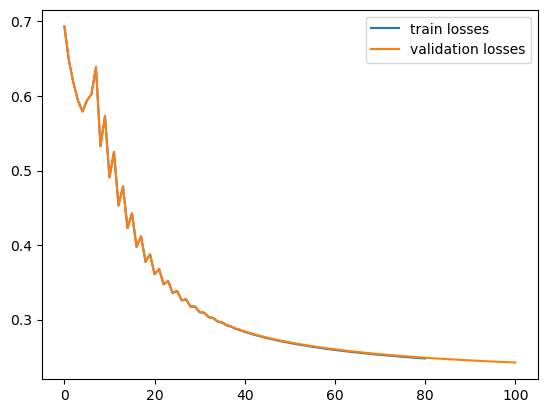

CPU times: total: 2min 51s
Wall time: 5min 10s


In [14]:
%%time

initial_w = np.zeros(x_tr_exp.shape[1])

max_iters = 100

gamma = best_gamma
lambda_ = best_lambda

w, losses, gen_losses = my_reg_logistic_regression(y_tr, x_tr_exp, y_val, x_val_exp, lambda_, initial_w, max_iters,
                                                   gamma)
plt.plot(losses)
plt.plot(gen_losses)
plt.legend(["train losses", "validation losses"])
plt.show()

### Testing

In [9]:
def recall(y_got, y_expected):
    true_positive = np.sum(np.where(y_got == 1, y_expected == 1, 0))
    return true_positive / sum(y_expected == 1)

In [10]:
def precision(y_got, y_expected):
    true_positive = np.sum(np.where(y_got == 1, y_expected == 1, 0))
    return true_positive / sum(y_got == 1)

In [11]:
def f1_score(y_got, y_expected):
    prec = precision(y_got, y_expected)
    rec = recall(y_got, y_expected)
    return 2 * prec * rec / (prec + rec)

In [18]:
x_train_full = np.concatenate((x_tr_exp, x_val_exp), axis=0)
y_got = x_train_full @ w

y_got[:] = 1 / (1 + np.exp(-y_got[:]))
y_got[:] = np.where(y_got[:] > 0.5, 1, 0)

f1 = f1_score(y_got, y_train)
rec = recall(y_got, y_train)
prec = precision(y_got, y_train)
print(f"F1: {f1}, recall: {rec}, precision: {prec}")

F1: 0.02178454192778275, recall: 0.012597066436583261, precision: 0.0804851157662624


In [34]:
x_test_exp = build_poly(x_test, degree)
for i in range(x_test_exp.shape[1]):
    x_test_exp[:, i] = (x_test_exp[:, i] - np.mean(x_test_exp[:, i])) / np.std(x_test_exp[:, i])
x_test_exp = np.c_[np.ones((x_test_exp.shape[0], 1)), x_test_exp]

result = x_test_exp @ w
result = np.c_[test_ids, result]
result

array([[ 3.28135000e+05, -4.52206511e+00],
       [ 3.28136000e+05,  2.19378802e+00],
       [ 3.28137000e+05, -5.08784565e+00],
       ...,
       [ 4.37511000e+05,  4.44217363e+00],
       [ 4.37512000e+05, -4.17574638e+00],
       [ 4.37513000e+05, -4.21684553e+00]])

In [35]:
# Sigmoid to classify
result[:, 1] = 1 / (1 + np.exp(-result[:, 1]))
result[:, 1] = np.where(result[:, 1] > 0.5, 1, -1)

result

array([[ 3.28135e+05, -1.00000e+00],
       [ 3.28136e+05,  1.00000e+00],
       [ 3.28137e+05, -1.00000e+00],
       ...,
       [ 4.37511e+05,  1.00000e+00],
       [ 4.37512e+05, -1.00000e+00],
       [ 4.37513e+05, -1.00000e+00]])

In [36]:
with open(f'{DATA_FOLDER}result.csv', 'w') as f:
    f.write('Id,Prediction\n')
    for row in result:
        f.write(f'{int(row[0])},{int(row[1])}\n')

## Ridge Regression

In [16]:
degree = 3

x_train_exp = build_poly(x_train, degree)

# Scaling each column
for i in range(x_train_exp.shape[1]):
    x_train_exp[:, i] = (x_train_exp[:, i] - np.mean(x_train_exp[:, i])) / np.std(x_train_exp[:, i])

# Adding an intercept
x_train_exp = np.c_[np.ones((x_train_exp.shape[0], 1)), x_train_exp]

In [22]:
%%time

initial_w = np.zeros(x_tr_exp.shape[1])

lambda_ = 0.7

w, loss = ridge_regression(y_train, x_train_exp, lambda_)

print(f"Loss: {loss}")

Loss: 0.03556195823861831
CPU times: total: 9.28 s
Wall time: 1.07 s


In [23]:
threshold = 5 * 1e-3

lambdas = np.logspace(0.0001, 1, 50)
above_threshold = []

for lambda_ in lambdas:
    w, loss = ridge_regression(y_train, x_train_exp, lambda_)
    count = len(w[np.where(w > threshold)])
    above_threshold.append(count)

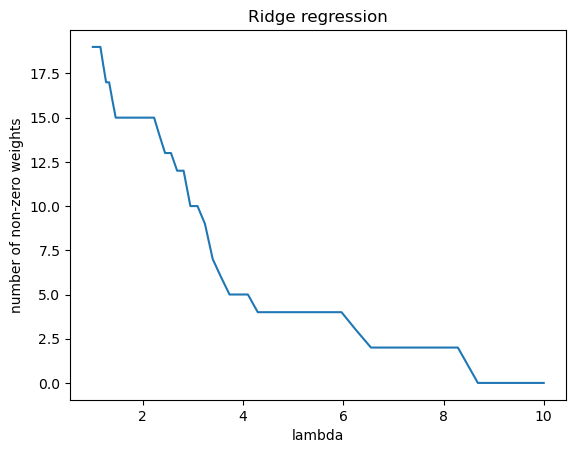

In [24]:
plt.plot(lambdas, above_threshold)
plt.xlabel('lambda')
plt.ylabel('number of non-zero weights')
plt.title('Ridge regression')
plt.show()

In [25]:
sorted(above_threshold)

[0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 7,
 9,
 10,
 10,
 12,
 12,
 13,
 13,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 17,
 17,
 18,
 19,
 19,
 19,
 19]